In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import re

In [4]:
# import NLTK and download required resources
import nltk
# nltk.download('punkt')  # For tokenization
# nltk.download('stopwords')  # For stop words
# nltk.download('wordnet')  # For lemmatization
# nltk.download('omw-1.4')  # For lemmatizer's extended language support

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [6]:
import sklearn

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
%ls data

cigar_aficionado.csv  clean_cigar_eda.csv   corpus_data.csv


In [9]:
file_name = '/Users/djbetts/Documents/data_science/projects/top-25-cigars/data/corpus_data.csv'
data = pd.read_csv(file_name)

In [10]:
df = data.copy()

In [11]:
df.columns

Index(['cigar_id', 'name', 'score', 'length', 'gauge', 'tasting_notes',
       'shape', 'filler', 'binder', 'wrapper', 'country', 'strength', 'issue',
       'issue_date', 'usd_value', 'word_count', 'clean_notes', 'tokens',
       'tokens_no_stopwords', 'lemmatized_tokens', 'corpus'],
      dtype='object')

In [12]:
# Initialize the TF-IDF Vectorizer with Bigrams and Unigrams
# vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # (1,2) includes both unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # unigrams only

In [13]:
# Fit and Transform the Corpus
tfidf_matrix = vectorizer.fit_transform(df['corpus'])
tfidf_matrix.shape

(18904, 4292)

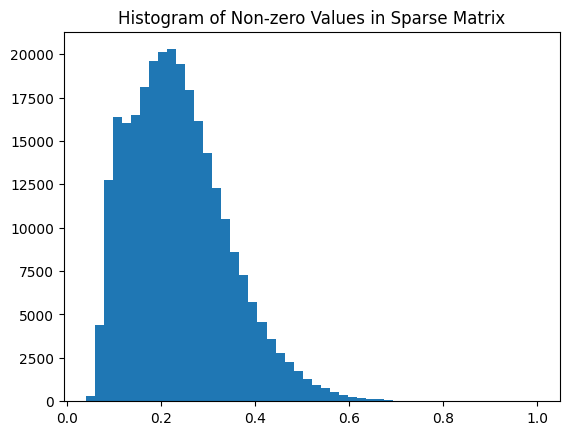

In [14]:
non_zero_values = tfidf_matrix.data  # Extract non-zero values directly
plt.hist(non_zero_values, bins=50)
plt.title("Histogram of Non-zero Values in Sparse Matrix")
plt.show()

In [15]:
# Display the shape of the TF-IDF matrix to check results
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (18904, 4292)


# viz of tfidf

In [16]:
# Get feature names (n-grams) and their corresponding TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# Compute average TF-IDF score for each feature across all documents
avg_tfidf_scores = np.mean(tfidf_scores, axis=0)

# Create a DataFrame with feature names and their average scores
tfidf_df = pd.DataFrame({
    'n-gram': feature_names,
    'avg_tfidf_score': avg_tfidf_scores
})

# Sort by TF-IDF score to see the most important terms
top_tfidf = tfidf_df.sort_values(by='avg_tfidf_score', ascending=False).head(5)
print(top_tfidf)

      n-gram  avg_tfidf_score
673    cigar         0.064423
1418  finish         0.051560
2468    note         0.049598
1462  flavor         0.047812
1136    draw         0.046396


In [17]:
# Print vectorizer settings
print("N-gram range:", vectorizer.ngram_range)
print("Number of features (terms):", len(vectorizer.get_feature_names_out()))
print("Lowercase:", vectorizer.lowercase)
print("Stop words:", vectorizer.stop_words)
print("Max features:", vectorizer.max_features)
print("Minimum document frequency (min_df):", vectorizer.min_df)
print("Maximum document frequency (max_df):", vectorizer.max_df)
print("Use IDF:", vectorizer.use_idf)
print("Smooth IDF:", vectorizer.smooth_idf)
print("Sublinear TF scaling:", vectorizer.sublinear_tf)

# Additionally, display the shape of the TF-IDF matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)  # (number of documents, number of terms)

N-gram range: (1, 1)
Number of features (terms): 4292
Lowercase: True
Stop words: None
Max features: None
Minimum document frequency (min_df): 1
Maximum document frequency (max_df): 1.0
Use IDF: True
Smooth IDF: True
Sublinear TF scaling: False
TF-IDF Matrix Shape: (18904, 4292)


In [18]:
#1. Visualize the TF-IDF Matrix as a Heatmap

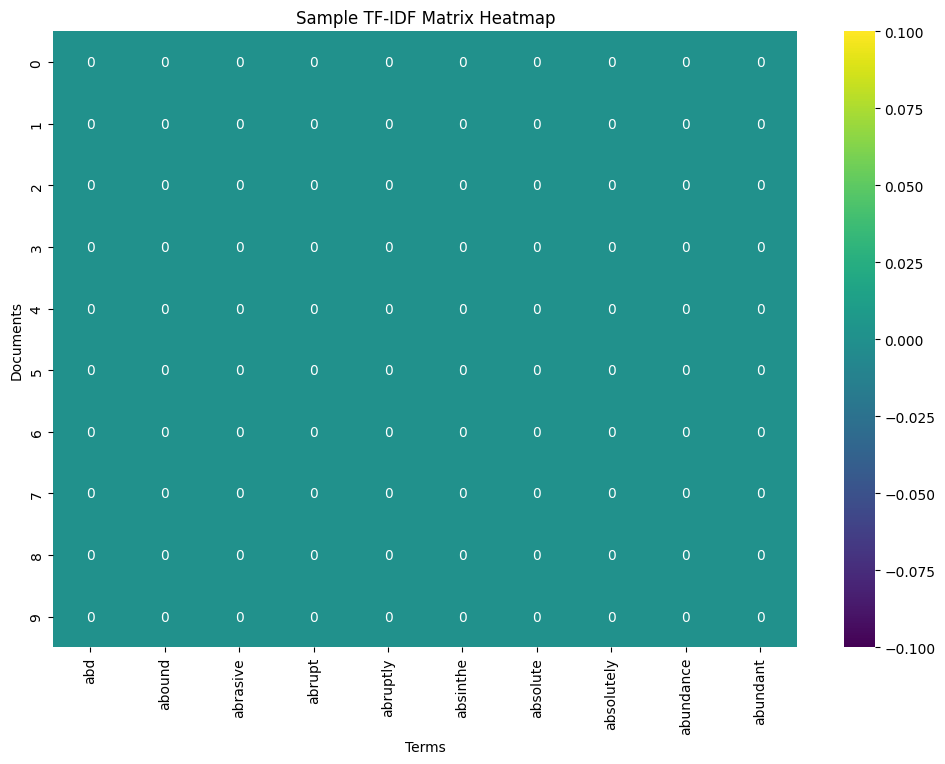

In [19]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display a heatmap of a sample of the TF-IDF matrix (for readability, use the first N rows)
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df.iloc[:10, :10], cmap="viridis", annot=True, cbar=True)  # Limit to first 10 documents and features
plt.title("Sample TF-IDF Matrix Heatmap")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.show()

In [20]:
#2. Find the Most Important Features Globally

In [21]:
# Calculate average TF-IDF score for each term
avg_tfidf = tfidf_df.mean().sort_values(ascending=False)

# Display the top N terms by average TF-IDF score
top_n = 10
print(f"Top {top_n} terms by average TF-IDF score:\n", avg_tfidf.head(top_n))

Top 10 terms by average TF-IDF score:
 cigar     0.064423
finish    0.051560
note      0.049598
flavor    0.047812
draw      0.046396
smoke     0.040174
burn      0.036070
woody     0.035914
hint      0.033505
medium    0.032849
dtype: float64


In [22]:
#3. Plot the Top N Important Terms

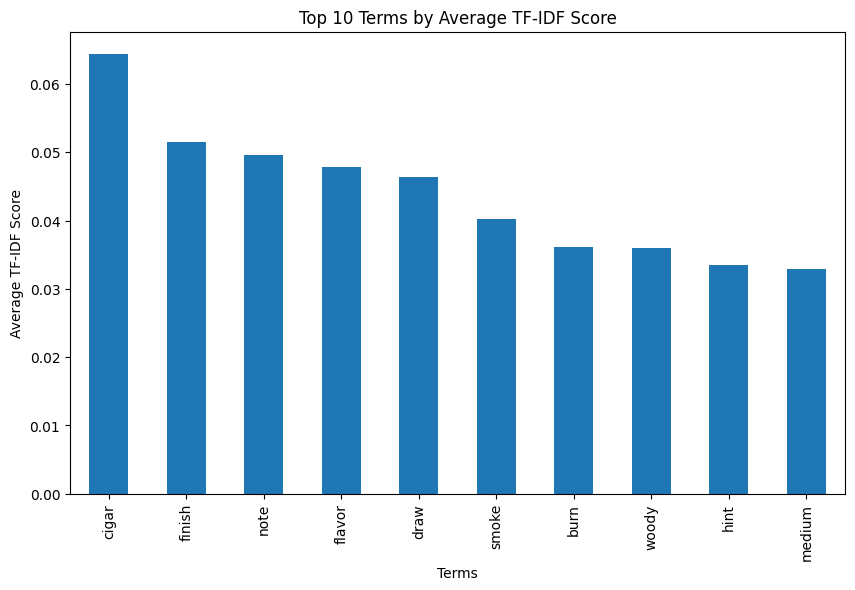

In [23]:
top_terms = avg_tfidf.head(top_n)

plt.figure(figsize=(10, 6))
top_terms.plot(kind='bar')
plt.title(f"Top {top_n} Terms by Average TF-IDF Score")
plt.xlabel("Terms")
plt.ylabel("Average TF-IDF Score")
plt.show()

In [24]:
#4. Identify Potential Stop Words

In [25]:
# Find terms with low average TF-IDF score (e.g., bottom 10 terms)
low_tfidf_terms = avg_tfidf.tail(10)
print("Potential Stop Words:\n", low_tfidf_terms)

Potential Stop Words:
 greatest         0.000015
world            0.000015
monterrey        0.000015
de               0.000015
medley           0.000015
york             0.000014
panatelasized    0.000014
batch            0.000014
auction          0.000014
came             0.000014
dtype: float64


# cosine similarity model

In [26]:
tfidf_matrix.shape

(18904, 4292)

In [27]:
# Calculate cosine similarity for the TF-IDF matrix
cosine_sim = cosine_similarity(tfidf_matrix)

In [28]:
cosine_sim.shape

(18904, 18904)

In [29]:
cosine_sim

array([[1.        , 0.08747542, 0.02815224, ..., 0.0114547 , 0.03945234,
        0.00837998],
       [0.08747542, 1.        , 0.05365304, ..., 0.05109953, 0.00508231,
        0.01182056],
       [0.02815224, 0.05365304, 1.        , ..., 0.03659179, 0.04463822,
        0.00874394],
       ...,
       [0.0114547 , 0.05109953, 0.03659179, ..., 1.        , 0.07678466,
        0.08755682],
       [0.03945234, 0.00508231, 0.04463822, ..., 0.07678466, 1.        ,
        0.05458695],
       [0.00837998, 0.01182056, 0.00874394, ..., 0.08755682, 0.05458695,
        1.        ]])

In [30]:
# sns.clustermap(cosine_sim, cmap='viridis', metric='cosine', method='average')
# plt.title("Cosine Similarity Clustered Heatmap")
# plt.show()

# testing and finding most similar cigars

In [31]:
# Create a DataFrame for the similarity matrix with cigar IDs
cigar_ids = [f'{i}' for i in range(cosine_sim.shape[0])]
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['cigar_id'], columns=df['cigar_id'])

In [32]:
cosine_sim_df

cigar_id,0,2,3,4,5,6,7,8,9,10,...,20761,20763,20764,20765,20767,20768,20769,20770,20771,20772
cigar_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.087475,0.028152,0.442191,0.011894,0.138217,0.174795,0.136352,0.000000,0.125911,...,0.013378,0.012979,0.027246,0.028553,0.055687,0.144506,0.041309,0.011455,0.039452,0.008380
2,0.087475,1.000000,0.053653,0.006760,0.022299,0.138857,0.077016,0.048776,0.005791,0.073784,...,0.020379,0.038742,0.027011,0.036669,0.023098,0.033237,0.005321,0.051100,0.005082,0.011821
3,0.028152,0.053653,1.000000,0.139695,0.045725,0.082930,0.024786,0.065925,0.000000,0.104314,...,0.031014,0.066985,0.038742,0.000000,0.047199,0.000000,0.000000,0.036592,0.044638,0.008744
4,0.442191,0.006760,0.139695,1.000000,0.016434,0.092398,0.032822,0.025945,0.000000,0.054284,...,0.007530,0.007305,0.040648,0.000000,0.022699,0.000000,0.000000,0.000000,0.059110,0.011579
5,0.011894,0.022299,0.045725,0.016434,1.000000,0.012676,0.010472,0.012673,0.007474,0.108771,...,0.019021,0.024098,0.029471,0.007325,0.033210,0.019285,0.006868,0.047057,0.034219,0.009601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20768,0.144506,0.033237,0.000000,0.000000,0.019285,0.000000,0.054785,0.066297,0.015555,0.227181,...,0.039459,0.032102,0.005241,0.058786,0.112918,1.000000,0.115878,0.025538,0.115700,0.019982
20769,0.041309,0.005321,0.000000,0.000000,0.006868,0.080158,0.036934,0.044013,0.089936,0.012700,...,0.091184,0.081026,0.032242,0.092111,0.207781,0.115878,1.000000,0.048508,0.226259,0.121283
20770,0.011455,0.051100,0.036592,0.000000,0.047057,0.074520,0.010085,0.049569,0.022164,0.067744,...,0.041777,0.070633,0.051932,0.072821,0.125659,0.025538,0.048508,1.000000,0.076785,0.087557


In [33]:
def get_top_two_similarities(df):
    data = {
        "target_cigar_id": [], 
        "n1_cigar_id": [], 
        "n1_score": [], 
        "n2_cigar_id": [], 
        "n2_score": []
    }
    
    for cigar_id in df.index:
        row = df.loc[cigar_id].copy()
        
        # Exclude self-similarity (diagonal) by setting it to -inf
        row[cigar_id] = -np.inf

        # Get the cigar with the highest similarity score (excluding the same cigar_id)
        most_similar_idx = row.idxmax()
        most_similar_score = row[most_similar_idx]
        
        # Set this score to -inf temporarily to find the next highest without including it again
        row[most_similar_idx] = -np.inf
        second_most_similar_idx = row.idxmax()
        second_most_similar_score = row[second_most_similar_idx]
        
        # Append to data dictionary
        data["target_cigar_id"].append(cigar_id)
        data["n1_cigar_id"].append(most_similar_idx)
        data["n1_score"].append(most_similar_score)
        data["n2_cigar_id"].append(second_most_similar_idx)
        data["n2_score"].append(second_most_similar_score)
        
    return pd.DataFrame(data)

In [34]:
# Apply the function and create the desired dataframe
similarity_df = get_top_two_similarities(cosine_sim_df)

In [35]:
similarity_df.isna().sum()

target_cigar_id    0
n1_cigar_id        0
n1_score           0
n2_cigar_id        0
n2_score           0
dtype: int64

In [36]:
import pandas as pd

def label_similarity_df(similarity_df, cigar_df):
    # Ensure that cigar_id columns are integers for consistent merging
    similarity_df['target_cigar_id'] = similarity_df['target_cigar_id'].astype(int)
    similarity_df['n1_cigar_id'] = similarity_df['n1_cigar_id'].astype(int)
    similarity_df['n2_cigar_id'] = similarity_df['n2_cigar_id'].astype(int)
    cigar_df['cigar_id'] = cigar_df['cigar_id'].astype(int)

    # Merge similarity_df with cigar_df to get the target cigar name
    labeled_df = similarity_df.merge(
        cigar_df, left_on="target_cigar_id", right_on="cigar_id", how="left"
    ).rename(columns={"name": "target_name"}).drop(columns="cigar_id")

    # Merge to get the name of n1_cigar
    labeled_df = labeled_df.merge(
        cigar_df, left_on="n1_cigar_id", right_on="cigar_id", how="left"
    ).rename(columns={"name": "n1_name"}).drop(columns="cigar_id")

    # Merge to get the name of n2_cigar
    labeled_df = labeled_df.merge(
        cigar_df, left_on="n2_cigar_id", right_on="cigar_id", how="left"
    ).rename(columns={"name": "n2_name"}).drop(columns="cigar_id")

    # Reorder columns as required
    labeled_df = labeled_df[
        ["target_cigar_id", "target_name", "n1_cigar_id", "n1_name", "n1_score", 
         "n2_cigar_id", "n2_name", "n2_score"]
    ]

    return labeled_df


In [37]:
output_df = label_similarity_df(similarity_df, df)

In [38]:
output_df.isna().sum()

target_cigar_id    0
target_name        0
n1_cigar_id        0
n1_name            0
n1_score           0
n2_cigar_id        0
n2_name            0
n2_score           0
dtype: int64

# search target_term return two similar cigars

In [39]:
def search_cigar_by_name(similarity_df, search_term):
    """
    Searches for cigars based on a partial text match in the target cigar name.

    Args:
        similarity_df (pd.DataFrame): DataFrame with 'target_cigar_name', 'most_similar_cigar_id', 
                                      'most_similar_cigar_name', 'most_similar_score', 
                                      'second_most_similar_cigar_id', 'second_most_similar_cigar_name', 
                                      and 'second_most_similar_score' columns.
        search_term (str): Text to search for in the 'target_cigar_name' column.

    Returns:
        pd.DataFrame: Filtered dataframe with matching results for easier inspection.
    """
    # Perform a case-insensitive search on target cigar names
    search_results = similarity_df[similarity_df['target_name'].str.contains(search_term, case=False, na=False)]
    
    # Display the relevant columns for inspection, including IDs
    return search_results

In [40]:
# Example usage: Assuming result_df is the merged dataframe from the previous function
# This will search for cigars with names similar to "robusto"
search_results = search_cigar_by_name(output_df, "flor de las")

In [41]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

search_results.sort_values('n1_score')

,target_cigar_id,target_name,n1_cigar_id,n1_name,n1_score,n2_cigar_id,n2_name,n2_score
13618,14423,FLOR DE LAS ANTILLAS TORO,16180,NEW WORLD NAVAGANTE,0.282259,14854,ROMEO Y JULIETA SHORT CHURCHILL,0.272833
17510,19142,FLOR DE LAS ANTILLAS BELICOSO,13737,H. UPMANN SUN GROWN CORONA,0.307819,13953,MONTECRISTO WHITE ESPECIAL NO. 1,0.273757
16330,17741,FLOR DE LAS ANTILLAS TORO GRANDE,19229,PADRÓN FAMILY RESERVE NO. 46 NATURAL,0.316373,16492,DAVIDOFF WINSTON CHURCHILL PETIT CORONA,0.316049
14627,15738,FLOR DE LAS ANTILLAS ROBUSTO,14776,ROCKY PATEL 15TH ANNIVERSARY ROBUSTO,0.322154,15973,LA ANTIGUEDAD ROBUSTO,0.281495
18824,20672,Flor de las Antillas Toro Grande,17640,PADILLA CONNECTICUT SHORT ROBUSTO,0.334535,15286,VILLIGER TALANGA TORO,0.318361
14556,15661,FLOR DE LAS ANTILLAS BELICOSO,18663,ALEC BRADLEY BLACK MARKET ESTELÍ TORPEDO,0.334660,19763,NAT CICCO ANIVERSARIO 1965 LIGA NO. 4 TORO,0.334503
13702,14525,FLOR DE LAS ANTILLAS TORO GORDO,12122,SIGLO LIMITED RESERVE SIGLO X,0.343610,15107,AVO DOMINANT 13TH,0.288715
15836,17168,FLOR DE LAS ANTILLAS BELICOSO,18812,MY FATHER THE JUDGE TORO FINO,0.350357,15895,CASA CUBA DOBLE CUATRO,0.292933
13583,14383,FLOR DE LAS ANTILLAS ROBUSTO,18108,LA GALERA 1936 BOX PRESSED CHURCHILL,0.368198,14020,PADRÓN SERIE 1926 MADURO NO. 6,0.318852
18288,20034,FLOR DE LAS ANTILLAS BELICOSO,12005,ASHTON ESTATE SUN GROWN 21 YEAR SALUTE,0.374990,19774,PAPPY VAN WINKLE TRADITION BELICOSO FINO,0.334035
